In [1]:
import os
import pandas as pd
import numpy as np
from helpers import VolleyWrapper, aggregate_similarities, aggregate_similarities_all, adjusted_r2
import tqdm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir('/Users/jniedziela/Developer/master/bpe/')

DATA_DIR = 'attack_pose_data/'
SCORES_DATA = 'attack_pose_data/pose_scores.xlsx'
JSON_DATA_DIR = 'attack_pose_data/json_files/'

/Users/jniedziela/.pyenv/versions/3.10.0/envs/bpe_2/lib/python3.10/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
scores = pd.read_excel(SCORES_DATA, index_col=0)[['pose_tabel', 'totaal_score']]
scores['json_file'] = scores['pose_tabel'].str.replace('.xlsx', '.json')
scores.sample(5)

,pose_tabel,totaal_score,json_file
15,GX010044_Clip_5_POSE_tabel.xlsx,2.477778,GX010044_Clip_5_POSE_tabel.json
1,GX010033_Clip_6_sec_14_POSE_tabel.xlsx,3.577778,GX010033_Clip_6_sec_14_POSE_tabel.json
35,GX010046_Clip_23_POSE_tabel.xlsx,2.388889,GX010046_Clip_23_POSE_tabel.json
32,GX010046_Clip_17_POSE_tabel.xlsx,4.311111,GX010046_Clip_17_POSE_tabel.json
24,GX010045_Clip_23_POSE_tabel.xlsx,3.466667,GX010045_Clip_23_POSE_tabel.json


In [3]:
vid1 = JSON_DATA_DIR + 'GX010042_Clip_6_sec_10_POSE_tabel.json'
vid2 = JSON_DATA_DIR + 'GX010033_Clip_6_sec_14_POSE_tabel.json'

analyser = VolleyWrapper(vid1, vid2)

# s1, s2 = analyser._load_seq_json()

sims = analyser.motion_similarity_per_window

## Compare with best score

In [5]:
best_scored_video = scores.sort_values('totaal_score', ascending=False).iloc[0]
display(best_scored_video)
best_scored_video_file = best_scored_video['json_file']

pose_tabel      GX010044_Clip_6_POSE_tabel.xlsx
totaal_score                                4.5
json_file       GX010044_Clip_6_POSE_tabel.json
Name: 16, dtype: object

In [27]:
results_df = pd.DataFrame(columns=['video_1', 'video_2', 'aggfunc', 'ra', 'la', 'rl', 'll', 'torso'])

vid_1_path = JSON_DATA_DIR + best_scored_video_file

for vid_2 in tqdm.tqdm(os.listdir(JSON_DATA_DIR)):
    vid_2_path = JSON_DATA_DIR + vid_2
    analyser = VolleyWrapper(vid_1_path, vid_2_path)
    sims = analyser.motion_similarity_per_window

    for aggfunc in [np.min, np.max, np.mean, np.std]:
        sims_avg = aggregate_similarities(sims, aggfunc)

        results_df.loc[len(results_df)] = [
            best_scored_video_file, 
            vid_2, 
            aggfunc.__name__,
            sims_avg['ra'], 
            sims_avg['la'], 
            sims_avg['rl'], 
            sims_avg['ll'], 
            sims_avg['torso']
            ]

100%|██████████| 43/43 [00:04<00:00,  9.79it/s]


In [34]:
model_results_df

,video_1,video_2,aggfunc,ra,la,rl,ll,torso,json_file,totaal_score
0,GX010044_Clip_6_POSE_tabel.json,GX010046_Clip_7_POSE_tabel.json,min,-0.727629,-0.062484,0.313783,0.222747,-0.059678,GX010046_Clip_7_POSE_tabel.json,3.477778
1,GX010044_Clip_6_POSE_tabel.json,GX010046_Clip_7_POSE_tabel.json,max,0.996128,0.983867,0.992615,0.994205,0.998457,GX010046_Clip_7_POSE_tabel.json,3.477778
2,GX010044_Clip_6_POSE_tabel.json,GX010046_Clip_7_POSE_tabel.json,mean,0.550740,0.483491,0.872292,0.785289,0.678643,GX010046_Clip_7_POSE_tabel.json,3.477778
3,GX010044_Clip_6_POSE_tabel.json,GX010046_Clip_7_POSE_tabel.json,std,0.461189,0.365738,0.182932,0.240906,0.320088,GX010046_Clip_7_POSE_tabel.json,3.477778
4,GX010044_Clip_6_POSE_tabel.json,GX010045_Clip_0_POSE_tabel.json,min,-0.187264,-0.549358,0.784519,-0.190645,0.297526,GX010045_Clip_0_POSE_tabel.json,3.483333
...,...,...,...,...,...,...,...,...,...,...
167,GX010044_Clip_6_POSE_tabel.json,GX010045_Clip_25_POSE_tabel.json,std,0.491479,0.673688,0.158739,0.267966,0.361405,GX010045_Clip_25_POSE_tabel.json,3.538889
168,GX010044_Clip_6_POSE_tabel.json,GX010045_Clip_5_POSE_tabel.json,min,-0.550684,0.124052,0.403640,-0.751812,0.319323,GX010045_Clip_5_POSE_tabel.json,3.394444
169,GX010044_Clip_6_POSE_tabel.json,GX010045_Clip_5_POSE_tabel.json,max,0.991016,0.998124,0.997319,0.977860,0.944436,GX010045_Clip_5_POSE_tabel.json,3.394444
170,GX010044_Clip_6_POSE_tabel.json,GX010045_Clip_5_POSE_tabel.json,mean,0.446658,0.709112,0.895005,0.367886,0.656389,GX010045_Clip_5_POSE_tabel.json,3.394444


In [28]:
model_results_df = results_df.merge(scores[['json_file', 'totaal_score']], left_on='video_2', right_on='json_file')
# model_results_df = pd.concat([model_results_df, pd.get_dummies(model_results_df['aggfunc'])], axis=1)

In [32]:
for aggfunc in ['min', 'max', 'mean', 'std']:

    data = model_results_df[model_results_df['aggfunc'] == aggfunc]

    linear = LinearRegression()
    X = data[['ra', 'la', 'rl', 'll', 'torso']]
    y = data['totaal_score']

    linear.fit(X, y)
    print(f'Aggregation function: {aggfunc}')
    print(f'Score: {linear.score(X, y)}\n')

Aggregation function: min
Score: 0.13910856887451128

Aggregation function: max
Score: 0.23464456526190103

Aggregation function: mean
Score: 0.20011875109927257

Aggregation function: std
Score: 0.15900463933226627



## Compare with best + window, stride param search

Do the same as in previous section, but check for different combinations of window and stride parameters

In [94]:
search_results = pd.DataFrame(columns=['window', 'stride', 'aggfunc', 'score'])

for window in tqdm.tqdm(range(15, 179, 5)):
    for stride in range(5, 185, 5):

        results_df = pd.DataFrame(columns=['video_1', 'video_2', 'aggfunc', 'ra', 'la', 'rl', 'll', 'torso'])

        vid_1_path = JSON_DATA_DIR + best_scored_video_file

        for vid_2 in os.listdir(JSON_DATA_DIR):
            vid_2_path = JSON_DATA_DIR + vid_2
            analyser = VolleyWrapper(vid_1_path, vid_2_path)
            analyser.set_window_size(window)
            analyser.set_stride_size(stride)
            sims = analyser.motion_similarity_per_window

            for aggfunc in [np.min, np.max, np.mean, np.std]:
                sims_avg = aggregate_similarities(sims, aggfunc)

                results_df.loc[len(results_df)] = [
                    best_scored_video_file, 
                    vid_2, 
                    aggfunc.__name__,
                    sims_avg['ra'], 
                    sims_avg['la'], 
                    sims_avg['rl'], 
                    sims_avg['ll'], 
                    sims_avg['torso']
                    ]
        model_results_df = results_df.merge(scores[['json_file', 'totaal_score']], left_on='video_2', right_on='json_file')


        for aggfunc in ['min', 'max', 'mean', 'std']:

            data = model_results_df[model_results_df['aggfunc'] == aggfunc]

            linear = LinearRegression()
            X = data[['ra', 'la', 'rl', 'll', 'torso']]
            y = data['totaal_score']

            linear.fit(X, y)
            score = linear.score(X, y)
            search_results.loc[len(search_results)] = [window, stride, aggfunc, score]
    

100%|██████████| 33/33 [2:02:39<00:00, 223.03s/it]  


In [120]:
search_results.sort_values('score', ascending=False).head(5)

,window,stride,aggfunc,score
67,15,85,std,0.402390
1163,55,15,std,0.400482
1327,60,40,std,0.380951
1155,55,5,std,0.378315
1184,55,45,min,0.377438


In [121]:
search_results.to_csv('analyses/window_stride_search_results.csv', index=False)

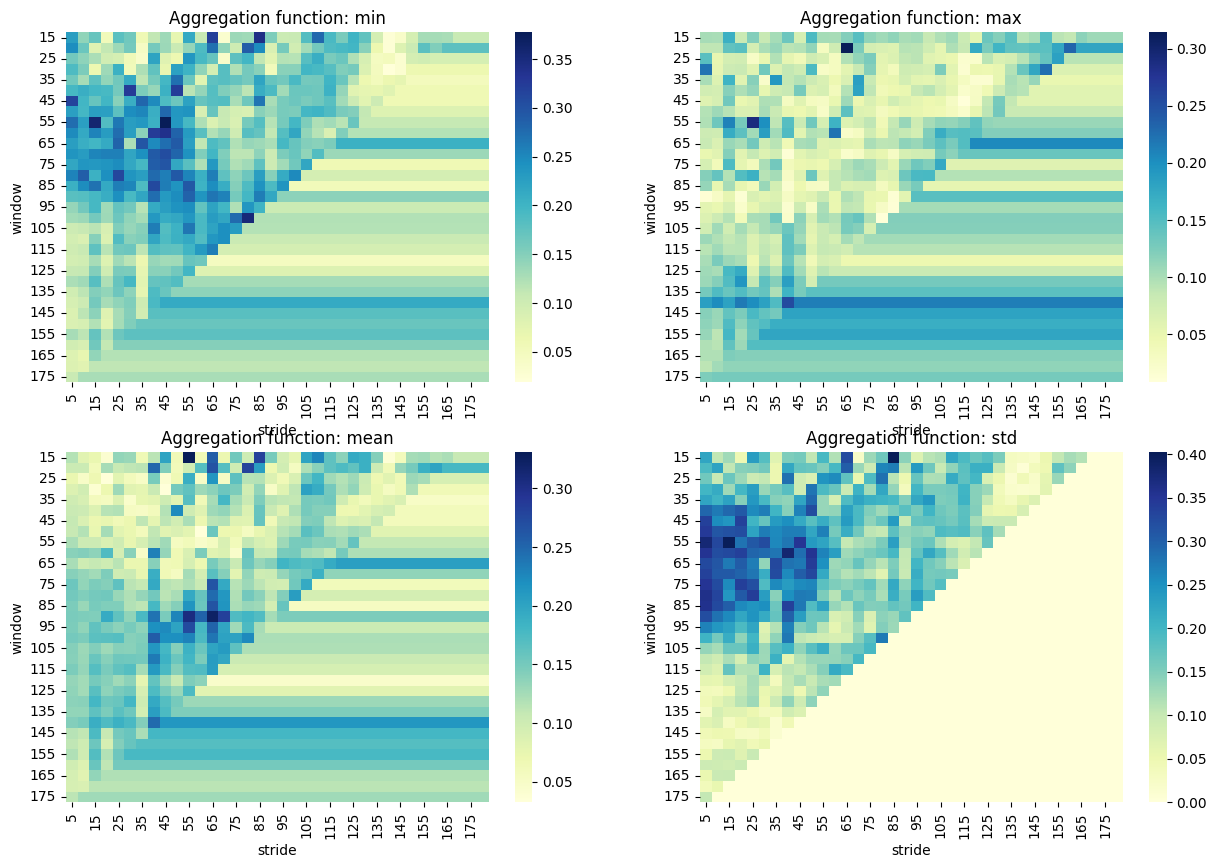

In [123]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))

for i, aggfunc in enumerate(['min', 'max', 'mean', 'std']):
    df = search_results[search_results['aggfunc'] == aggfunc]

    # Pivot the DataFrame to have 'window' as rows, 'stride' as columns, and 'score' as values
    pivot_df = df.pivot(index='window', columns='stride', values='score')

    # Plot heatmap
    sns.heatmap(pivot_df, cmap="YlGnBu", ax=ax[i//2, i%2])
    ax[i//2, i%2].set_title(f'Aggregation function: {aggfunc}')


In [ ]:
# X = ['la_min', 'ra_min'.....]

## Compare with best using all aggregations 

In [7]:
aggregate_similarities_all(sims)

{'ra_min': -0.31069129705429077,
 'la_min': -0.42191028594970703,
 'rl_min': 0.9007374048233032,
 'll_min': 0.6387001872062683,
 'torso_min': 0.011795378290116787,
 'ra_max': 0.9212168455123901,
 'la_max': 0.968706488609314,
 'rl_max': 0.9971420764923096,
 'll_max': 0.9996052384376526,
 'torso_max': 0.9656077027320862,
 'ra_mean': 0.5275024988434531,
 'la_mean': 0.46949589387937024,
 'rl_mean': 0.9546072970737111,
 'll_mean': 0.9412558783184398,
 'torso_mean': 0.6714970096099105,
 'ra_std': 0.2984470667306108,
 'la_std': 0.45812050507484825,
 'rl_std': 0.02671598701740751,
 'll_std': 0.10058560192863972,
 'torso_std': 0.28003313981260647}

In [10]:
AGG_COLS = ['ra_min', 'la_min', 'rl_min', 'll_min', 'torso_min', 'ra_max', 'la_max', 'rl_max', 'll_max', 'torso_max', 'ra_mean', 'la_mean', 'rl_mean', 'll_mean', 'torso_mean', 'ra_std', 'la_std', 'rl_std', 'll_std', 'torso_std']
search_results = pd.DataFrame(columns=['window', 'stride', 'score'])

for window in tqdm.tqdm(range(15, 179, 5)):
    for stride in range(5, 185, 5):

        results_df = pd.DataFrame(columns=['video_1', 'video_2'] + AGG_COLS)

        vid_1_path = JSON_DATA_DIR + best_scored_video_file

        for vid_2 in os.listdir(JSON_DATA_DIR):
            vid_2_path = JSON_DATA_DIR + vid_2
            analyser = VolleyWrapper(vid_1_path, vid_2_path, window, stride)
            sims = analyser.motion_similarity_per_window

            sims_agg = aggregate_similarities_all(sims)

            results_df.loc[len(results_df)] = [
                best_scored_video_file, 
                vid_2, 
                *list(sims_agg.values())
                ]
            
        model_results_df = results_df.merge(scores[['json_file', 'totaal_score']], left_on='video_2', right_on='json_file')

        linear = LinearRegression()
        X = model_results_df[AGG_COLS]
        y = model_results_df['totaal_score']

        linear.fit(X, y)
        score = linear.score(X, y)
        search_results.loc[len(search_results)] = [window, stride, score]

        if len(sims) == 1:
            break
    

100%|██████████| 33/33 [25:47<00:00, 46.89s/it]


In [1]:
import math
def show_analysed_frames(seq_length, window_size, stride_size):
    '''
    >>> show_analysed_frames(60, 30, 15)
    Range =  3
    From: 0  To:  30
    From: 15  To:  45
    From: 30  To:  60
    '''
    print('Range = ', math.ceil(((seq_length - window_size + 1) / stride_size)))
    for i in range(math.ceil(((seq_length - window_size + 1) / stride_size))):
        # seq[:, :, i * stride: i * stride + window_size]
        print('From:', i * stride_size, ' To: ', i * stride_size + window_size)

In [4]:
show_analysed_frames(183, 45, 65)

Range =  3
From: 0  To:  45
From: 65  To:  110
From: 130  To:  175


In [5]:
show_analysed_frames(183, 45, 70)

Range =  2
From: 0  To:  45
From: 70  To:  115


In [ ]:
# Feature importance for highest scores window/stride combination
# might have different feature for ra_max/other for different window/stride

<Axes: xlabel='stride', ylabel='window'>

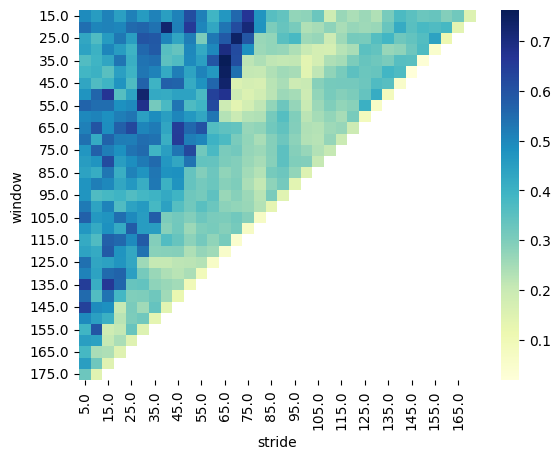

In [12]:
pivot_df = search_results.pivot(index='window', columns='stride', values='score')

# Plot heatmap
sns.heatmap(pivot_df, cmap="YlGnBu")

## Comapre diff

Compares difference between videos custom score and aggregated sim output.

In [34]:
import itertools

In [85]:
def window_stride_grid_search_diff(window_range, stride_range, cols_to_use, y_col):
    AGG_COLS = ['ra_min', 'la_min', 'rl_min', 'll_min', 'torso_min', 'ra_max', 'la_max', 'rl_max', 'll_max', 'torso_max', 'ra_mean', 'la_mean', 'rl_mean', 'll_mean', 'torso_mean', 'ra_std', 'la_std', 'rl_std', 'll_std', 'torso_std']
    unique_video_pairs = list(itertools.combinations_with_replacement(os.listdir(JSON_DATA_DIR), 2))
    search_results = pd.DataFrame(columns=['window', 'stride', 'score', 'adj_r2'])

    for window in tqdm.tqdm(window_range):
        for stride in stride_range:
            results_df = pd.DataFrame(columns=['video_1', 'video_2', 'diff'] + AGG_COLS)


            for (vid_1, vid_2) in unique_video_pairs:
                
                vid_1_path = JSON_DATA_DIR + vid_1
                vid_1_score = scores[scores['json_file'] == vid_1]['totaal_score'].iloc[0]

                vid_2_path = JSON_DATA_DIR + vid_2
                vid_2_score = scores[scores['json_file'] == vid_2]['totaal_score'].iloc[0]

                analyser = VolleyWrapper(vid_1_path, vid_2_path, window, stride)
                sims = analyser.motion_similarity_per_window

                sims_agg = aggregate_similarities_all(sims)

                results_df.loc[len(results_df)] = [
                    vid_1, 
                    vid_2, 
                    np.abs(vid_1_score - vid_2_score),
                    *list(sims_agg.values())
                    ]

            model_results_df = results_df.merge(scores[['json_file', y_col]], left_on='video_2', right_on='json_file')

            linear = LinearRegression()
            X = model_results_df[cols_to_use]
            y = model_results_df[y_col]

            linear.fit(X, y)
            score = linear.score(X, y)
            adj_r2 = adjusted_r2(score, len(y), len(X.columns))
            search_results.loc[len(search_results)] = [window, stride, score, adj_r2]

            if len(sims) == 1:
                break

    return search_results

In [94]:
res = window_stride_grid_search_diff(range(15, 180, 5), range(5, 180, 5), AGG_COLS, 'totaal_score')


100%|██████████| 33/33 [9:30:16<00:00, 1036.88s/it]  


In [96]:
res.sort_values('score', ascending=False).head(5)

,window,stride,score,adj_r2
38,20.0,25.0,0.179529,0.161789
550,140.0,5.0,0.171949,0.154045
567,150.0,5.0,0.170787,0.152858
560,145.0,10.0,0.170656,0.152724
569,150.0,15.0,0.167492,0.149492


Text(0.5, 1.0, 'Adjusted R2 heatmap')

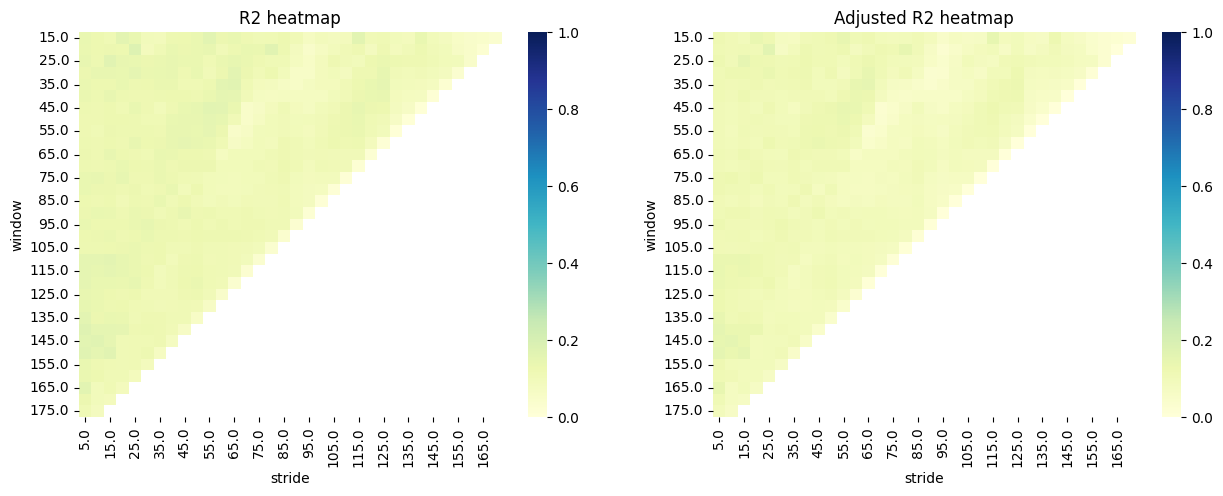

In [98]:
pivot_df1 = res.pivot(index='window', columns='stride', values='score')
pivot_df2 = res.pivot(index='window', columns='stride', values='adj_r2')

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
# Plot heatmap
sns.heatmap(pivot_df1, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[0])
ax[0].set_title('R2 heatmap')

sns.heatmap(pivot_df2, cmap="YlGnBu", vmin=0, vmax=1, ax=ax[1])
ax[1].set_title('Adjusted R2 heatmap')